# Health Lifestyle Prediction App

The goal of this notebook is to analyze data consisting of resting heart rate, active heart rate, BMI and VO2 max for 3000 users for 1 year in order to create a health lifestyle prediction app where the user can input their said features and be classified into one of the three classes - 'sedentary','cardio trainer' or 'weight trainer'. With this web-app, gyms can classify their incoming customers which can help personal trainers create more personalised routines for them.

**The final web-app can be accessed here:** https://health-lifestyle-prediction.herokuapp.com/

## Importing Libraries

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import pickle

## Loading and Pre-processing Data

In [54]:
#loading data
health1 = pd.read_csv('health_profile1.csv')
health2 = pd.read_csv('health_profile2.csv')
users = pd.read_csv('user_profile.csv')

The data consists of 1 year of resting and active heartrate, BMI, VO2max, workout minutes for 3000 users along with their profiles which consists of sec, name and the lifestyle they have.

In [55]:
#concatenating health profiles
health = pd.concat([health1,health2])

In [56]:
health.head()

,dte,_id,resting_heartrate,active_heartrate,BMI,VO2_max,workout_minutes
0,2019-01-01T00:00:00.000Z,d252b8e4-e48a-11ea-8204-0242ac110002,69.231203,118.593868,31.061184,29.334252,21.256854
1,2019-01-02T00:00:00.000Z,d252b8e4-e48a-11ea-8204-0242ac110002,64.440649,125.716382,26.951372,29.440784,27.449360
2,2019-01-03T00:00:00.000Z,d252b8e4-e48a-11ea-8204-0242ac110002,61.044428,124.465805,26.131978,29.432059,12.849808
3,2019-01-04T00:00:00.000Z,d252b8e4-e48a-11ea-8204-0242ac110002,59.843270,117.160802,26.654132,29.504870,18.331979
4,2019-01-05T00:00:00.000Z,d252b8e4-e48a-11ea-8204-0242ac110002,67.344985,119.226623,28.483918,29.310455,17.300341


In [57]:
users.head()

,_id,first_name,last_name,lifestyle,female,country,occupation
0,d252b8e4-e48a-11ea-8204-0242ac110002,Sheila,Schneider,weight trainer,True,USA,Sales
1,d2599542-e48a-11ea-8204-0242ac110002,Shane,Simpson,weight trainer,False,USA,Adm-clerical
2,d25d89a4-e48a-11ea-8204-0242ac110002,Joshua,Bishop,weight trainer,False,USA,Handlers-cleaners
3,d261ca5a-e48a-11ea-8204-0242ac110002,Charles,Gonzalez,weight trainer,False,BRA,Armed-Forces
4,d265d7f8-e48a-11ea-8204-0242ac110002,Christine,Hobbs,weight trainer,True,BRA,Transport-moving


I will aggregate the user data based on average values. Mean values were chosen in place of median since we can capture the high or low skewness better with mean which is desired in this application. Additionally for the final web-app, avergae is more intuitive to the general population when compared to median.

In [58]:
#groupby user id and aggregating mean data
health = health.groupby('_id').mean().reset_index()

In [59]:
#joining user profile and their health profiles on user id
df = pd.merge(users,health,on='_id',how='left')

In [60]:
df.head()

,_id,first_name,last_name,lifestyle,female,country,occupation,resting_heartrate,active_heartrate,BMI,VO2_max,workout_minutes
0,d252b8e4-e48a-11ea-8204-0242ac110002,Sheila,Schneider,weight trainer,True,USA,Sales,63.656352,121.667119,27.990443,29.286745,27.616948
1,d2599542-e48a-11ea-8204-0242ac110002,Shane,Simpson,weight trainer,False,USA,Adm-clerical,62.183777,112.501443,24.555585,35.035212,26.965237
2,d25d89a4-e48a-11ea-8204-0242ac110002,Joshua,Bishop,weight trainer,False,USA,Handlers-cleaners,61.571203,120.648993,27.755261,29.849465,26.191230
3,d261ca5a-e48a-11ea-8204-0242ac110002,Charles,Gonzalez,weight trainer,False,BRA,Armed-Forces,59.881601,116.911842,26.600618,32.838485,27.036928
4,d265d7f8-e48a-11ea-8204-0242ac110002,Christine,Hobbs,weight trainer,True,BRA,Transport-moving,60.025780,115.374273,25.409382,33.135436,25.342679


I now have my final dataframe. Although this is a very interesting dataset, my focus is to analyse the heartrates, BMI and VO2 max for various lifestyles and at the end create a web-app which classifies the user to the various lifestyles based on their heartrates, BMI and VO2_max. These features are chosen as these can be readily checked and inputted into the webapp.

In [61]:
#keeping relevant columns
df = df[['lifestyle','resting_heartrate','active_heartrate','BMI','VO2_max']]

## Exploratory Data Analysis

Let's look at the various lifestyles that will be the target for the classification model as well

In [62]:
#looking at value counts for our target
df['lifestyle'].value_counts()

sedentary         1000
cardio trainer    1000
weight trainer    1000
Name: lifestyle, dtype: int64

This is a perfectly balanced dataset. Incase it was imbalanced, undersampling or oversampling can be done so that our model is not biased towards one class.

In [63]:
#creating features and target to analyse
features = df.drop(['lifestyle'],axis=1)
target = df[['lifestyle']]

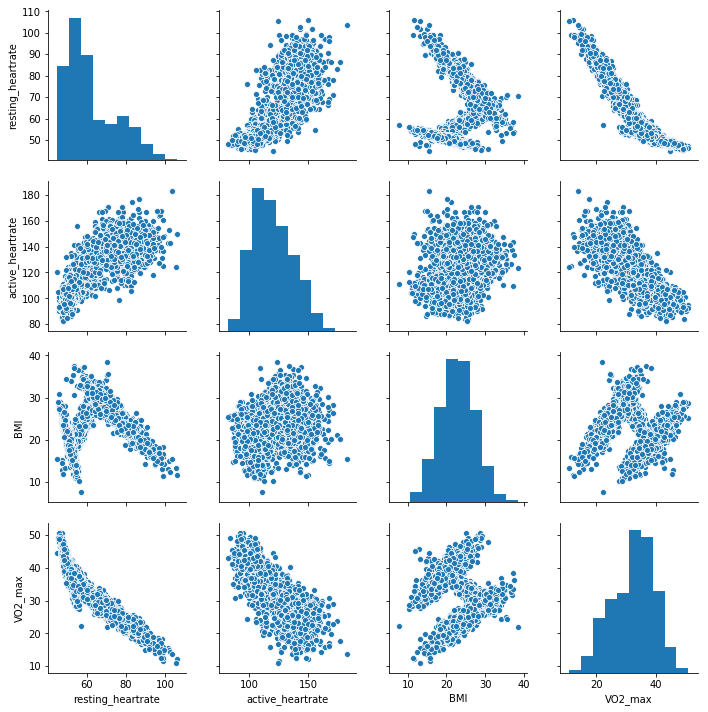

In [64]:
#looking at pairplots to analyse correlation between features
sns.pairplot(features)

It seems like VO2 and resting heartrate exhibit high negative linear relationship and VO2 max. This makes sense since VO2 is the oxygen available to the user while working out and with lower resting_heartrate, higher oxygen will be availble. Also all features exhibit a little linear relationships except BMIE which can pose a problem while building the model. 

I will dive a bit deeper to explore the distributions and the correlations in the following sections of the EDA

C:\Users\harsh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


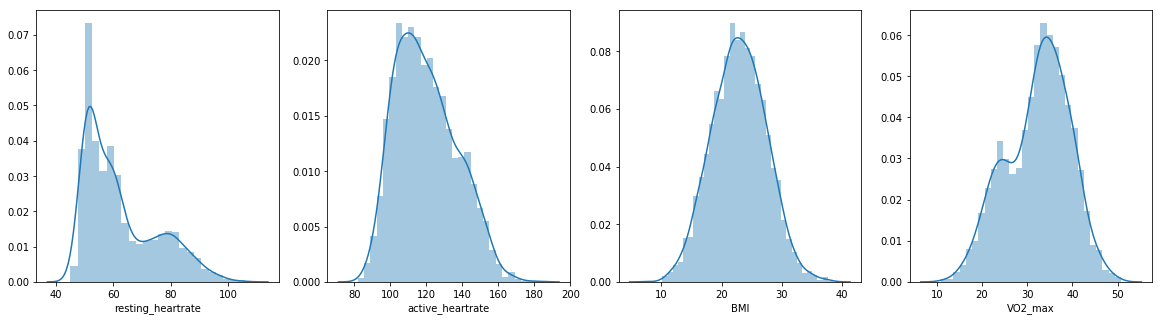

In [65]:
#printing distributions for each feature
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i, feature in enumerate(features):
    sns.distplot(features[feature], ax=ax[i])

active_heartrate and BMI seems to be normally distributed whereas resting heartrate ad VO2 max show a bit of skewness. I will keep this in mind during feature selection. But let us look at these distributions for each lifestyle.

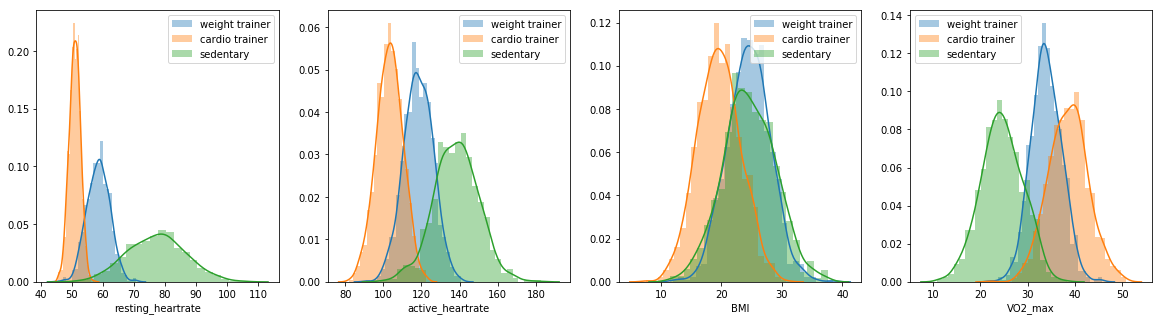

In [66]:
#printing distributions for each feature coloured for each lifestyle
fig, ax = plt.subplots(1,4, figsize=(20,5))
lifestyles = target['lifestyle'].unique().tolist()

#iterates through features
for i, feature in enumerate(features): 
   
    #iterates through lifestyles
    for lifestyle in lifestyles: 
        
        subset = features[target['lifestyle'] == lifestyle]
        sns.distplot(subset[feature], ax=ax[i], label=lifestyle)
        ax[i].legend()

#### We can clearly see distinct differences between each lifestyles now.

Cardio trainers seem to have a lower heartrates than other two lifestyles and a higher VO2 max.

As we noticed in the pair plot, the bmi is overlapping quite a bit but weight trainers might have more because they carry more muscles/mass and thus weight more, whereas, sedentary might have more fat levels in general. Also cardio trainers also might weigh lower than the other two classes which shows in BMI as well.

Heart Rates and VO2 seems better for training classes than sedentary classes which gives more incentive to exercise!

I will now try to get correlations for each features and hopefully as our EDA showed their might be some correlations

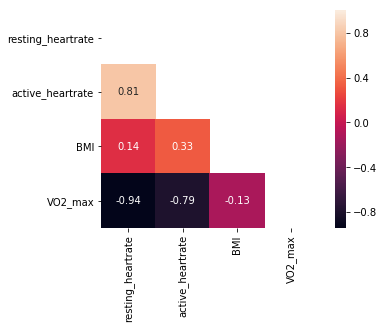

In [67]:
#computing pearson correlations for all the features
#this code block creates a mask to display only the half of the heatmap
corr = features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 0)] = True
sns.heatmap(corr, mask=mask, square=True, annot=True)

We can now look at how our data actually looks like in 2-D. I will use TSNE for dimensionality reduction from 4 dimensions to 2 dimensions so we can project our feature space in order to visualise them. What I want to see is whether the data is easily separable or not.

In [68]:
#fit_transform TSNE to reduce to 2 components/dimension
np.random.seed(10)
tsne = TSNE(n_components=2)

features_in_two_dimensions = tsne.fit_transform(features)
features_in_two_dimensions = pd.DataFrame(features_in_two_dimensions)

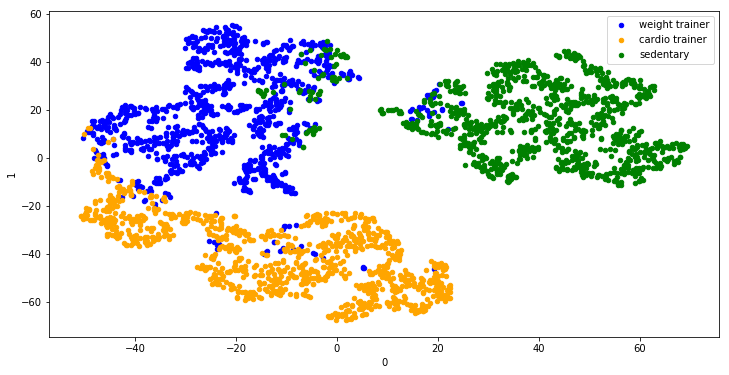

In [69]:
#visualising the 2-D feature space by zipping the lifestyle to a color and plotting it 
colors = ("blue", "orange", "green")
fig, ax = plt.subplots(1,1,figsize=(12,6))

for color, lifestyle in zip(colors, lifestyles):
    two_dim_per_lifestyle = features_in_two_dimensions[target.lifestyle == lifestyle]
    two_dim_per_lifestyle.plot(x=0, y=1, kind="scatter", c=color, label=lifestyle, ax=ax)

Sedentary is quite clearly differentated than cardio trainer but we can see that weight trainers have some data points that overlap with the sedentary and cardio groups.

The data seems to be easily separabale which means we can potentially achieve a good metric

I will now create the model to classfiy the data into lifestyle. First, I will label encode the target.

## Model Building - Baseline Models

In [70]:
# category codes corresponding to the lifestyle
dict(enumerate(target['lifestyle'].astype('category').cat.categories))

{0: 'cardio trainer', 1: 'sedentary', 2: 'weight trainer'}

In [71]:
#label encoding target
target['lifestyle'] = target['lifestyle'].astype('category').cat.codes

C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Although I can use the TSNE 2-D data, I am going to use all the features.

In order to evaluate the performance of the base models, I will be using a fixed train-test split and will utilise cross validation later for hyperparameter tuning. Additionally, I am choosing F1 Score as the metric to track the model performance since I want to capture both the precision and recall of the classes and also since accuracy can be easily skewed based on the good model performance of one class.

In [73]:
#splitting data into train-test
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3)

I will first use a Logistic Regression as a baseline as the data seems to be linearly separable.

In [75]:
#fitting model and printing classification report
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       341
           1       0.93      0.93      0.93       299
           2       0.77      0.83      0.80       260

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


As I suspected, baseline model is doing extremely good with a F1-Score of 0.92. The model gave us a warning that the lr model is not converging, so we can already imporve on our baseline by increasing the maximum number of iterations.

In [76]:
#fitting model and printing classification report

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
print(classification_report(predictions,y_test))

C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       333
           1       0.95      0.98      0.96       291
           2       0.93      0.93      0.93       276

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



Now our basline model has been improved even further as we are getting an F1 score of 0.95. We can try some other models to further try to increase the metric value.

In [77]:
#fitting model and printing classification report

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
print(classification_report(predictions,y_test))

C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       328
           1       0.98      0.98      0.98       299
           2       0.96      0.97      0.97       273

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



As we can see above, without any feature engineering and hyperparameter optimization, the base RandomForest is giving the best result so far and thus we will choose it as our model we can tune our hyperparameters on.

## Model Building - Feature Engineering and Hyperparameter Tuning

As it was seen in our EDA that active and resting heartrate are highly positively correleted and as well as VO2 max and resting heatrate are highly negative correlated, we can remove the multicollinear features. This decision is also taken so that for our end goal of building the web-app, the user has to only input their resting heartrate and their BMI in order to get classified into a lifestyle.

In [303]:
#keeping only relevant features as described above
features = features[['resting_heartrate','BMI']]

In [304]:
#fitting model and printing classification report

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       303
           1       0.93      0.96      0.95       276
           2       0.93      0.93      0.93       321

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


The F1-Score did go down but from the user perspective I made the web app more widely and easily usable, thus it is fair tradeoff. We can try to increase the F1 score now using hyperparameter tuning.

In [305]:
#the default parameters for random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [306]:
#constructing parameter grid for the random forest classifier
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 20 , 40, 60, 80],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2,4,6, 8],
    'n_estimators': [100, 200, 300, 1000]
}


In [307]:
rf = RandomForestClassifier()

In [308]:
#initiating grid search with f1 score as the scoring metric
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring ='f1_weighted',
                          cv = 3, n_jobs = -1, verbose = 2)

In [309]:
#fitting grid search
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  6.2min finished
C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example us

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [None, 20, 40, 60, 80],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring='f1_weighted', verbose=2)

In [310]:
#best rf parameters based on hyperparameter tuning
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [311]:
#best rf 
best_rf = grid_search.best_estimator_

## Model Building - Final Model Results

In [312]:
#prinitng classification report for best rf model after tuning hyperparameters

predictions = best_rf.predict(X_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       305
           1       0.94      0.97      0.95       274
           2       0.94      0.93      0.94       321

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



I did manage to squeeze out extra 0.01 improvement on our F1_score and for all the classes except weight trainer this looks good.

I will now save the model in a pickle file and then use streamlit and heroku to deploy the webapp.

In [314]:
#saving model weights for deployment
pickle.dump(best_rf, open('health_app_rf_weights.pkl', 'wb'))

The repository for the model deployment can be found here: https://github.com/harshulvarma/health_lifestyle_app

The final web-app can be found here: https://health-lifestyle-prediction.herokuapp.com/